In [8]:
!pip install loompy scprep phate magic-impute velocyto

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 41 kB 63 kB/s s eta 0:00:01
  Using cached velocyto-0.17.17.tar.gz (198 kB)
     |████████████████████████████████| 109 kB 9.8 MB/s eta 0:00:01
     |████████████████████████████████| 10.2 MB 12.1 MB/s eta 0:00:01
  Created wheel for loompy: filename=loompy-3.0.6-py3-none-any.whl size=47896 sha256=febb264ef4d58808452251ec918782dbd8b93b9d58d013d1aeba761f74e61854
  Stored in directory: /home/scottgigante/.cache/pip/wheels/cb/f8/3f/7072a3f75b1488b4488c41a2b8bcba3d51a0c5c1787a7034cd
  Created wheel for velocyto: filename=velocyto-0.17.17-cp38-cp38-linux_x86_64.whl size=505231 sha256=2d30621aa87d459dc4c85513801c34556f522b4ea5ed95872223c75dc0a38914
  Stored in directory: /home/scottgigante/.cache/pip/wheels/cd/04/13/c47273eed9825d383b6501e7460ef3400922deb21fea639b6a
  Created wheel for numpy-groupies: filename=numpy_groupies-0.9.13-py3-none-any.whl size=24067 sha256=199ef6ea8

#### Install R packages

In [2]:
import scprep

In [ ]:
scprep.io.download.download_google_drive("10FpYcwqXBrG_K0p5Cq936lmH6F9sO70x", 'r_packages.tar.gz')
!tar xzf r_packages.tar.gz  -C /usr/local/lib/R/site-library/ && rm r_packages.tar.gz
!apt-get install -yqq libgsl-dev=2.4+dfsg-6
!pip install --upgrade rpy2
!R -e "BiocManager::install('slingshot')"

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import tarfile

import velocyto
import phate

# Running RNA-velocity on the EB dataset

Calculating RNA velocity involves two main steps:
1. Generate loom files with information about spliced and unspliced genes
2. Estimating the rate of transcription for each gene
3. Predicting future cell state given the spliced/unspliced ratio of genes in each cell

We already performed the first step because this takes a long time and a lot of computational resources. If you want to learn how to generate loom files, please consult the RNA velocity tutorials (http://velocyto.org/velocyto.py/tutorial/index.html). The syntax is fairly straightforward.

In this exercise, we will perform steps 2 and 3 to estimate the transcriptional velocity for each cell.

## 1. Downloading and loading the loom files

Running estimating RNA velocity requires a special `VelocytoLoom` object. Here we create this object using the loom file generated from the fastq files.

### Downloading the `loom` files


In [10]:
download_dir = os.path.expanduser('~')
download_path = os.path.join(download_dir, '2017_Krishnaswamy_EB_velocity.tar.gz')

# Download the data tarball
if not os.path.exists(download_path):
    scprep.io.download.download_google_drive('1FDDSWtSZcdQUVKpk-mPCZ8Ji1Fx8KSz9', download_path)

# Extract data directory
with tarfile.open(download_path) as tf:
    tf.extractall(download_dir)

# Format the data paths
data_dir = os.path.join(download_dir, '2017_Krishnaswamy_EB_velocity')

### Loading the loom files

Designed for large omics datasets, loom files are essentially specially formatted HDF5 tables that store data and metadata in a single container. You can read more about loom files here: http://loompy.org/.

We will load the `loom` files with `velocyto`, the RNA velocity toolkit.

In [11]:
# Load the data
data_loom = velocyto.VelocytoLoom(os.path.join(data_dir, 'EBT_velocity.loom'))

# Keep only cells that passed QC as determined in Moon et al. (2019)
keep_cells = np.load(os.path.join(data_dir,'EBT_filtered_cells.npy'))

# Subsample to keep colab from crashing
keep_cells = scprep.select.subsample(keep_cells, n=6000)

# We ran PHATE earlier to save time
data_phate = pd.read_pickle(os.path.join(data_dir,'EBT_phate_coordinates.pkl'))

#### Processing the loom file

Velocyto has a lot of complicated plotting functions that require attributes be stored in specific slots in order to create the plots showcased in the paper. Because of this, the following code block is a little opaque. As a reminder, all of this code was generated following the Velocyto tutorials, and  you should probably follow their tutorials if you want to run RNA velocity on your data.

In [12]:
# Get the list of kept barcodes from saved numpy, then filter loom object by them
to_keep = np.isin(data_loom.ca['CellID'], keep_cells)
data_loom.filter_cells(to_keep)

# Coerce the data into a nice format
data_phate = data_phate[data_loom.ca['CellID']].T

# Storing sample labels in the column attributes 
samples = ['EBT0_1A', 'EBT2_3B', 'EBT4_5C', 'EBT6_7D', 'EBT8_9E']
data_loom.ca['Sample'] = np.array([s.split(':')[0] for s in data_loom.ca['CellID']])
sample_index_map = dict(zip(np.unique(data_loom.ca['Sample']), range(5)))
data_loom.ca['Sample_idx'] = np.array([sample_index_map[s] for s in data_loom.ca['Sample']])

# Adding nicely formatted cluster labels
nice_samples = ["Day 00-03", "Day 06-09", "Day 12-15", "Day 18-21", "Day 24-27"]
sample_nice_map = dict(zip(samples, nice_samples))
data_loom.ca['Sample_nice'] = np.array([sample_nice_map[s] for s in data_loom.ca['Sample']])
data_loom.cluster_labels = data_loom.ca['Sample_nice']

# Adding PHATE coordinates to the loom object
data_loom.ts = data_phate.to_numpy()
colors_dict = dict(zip(samples, plt.cm.Spectral(np.linspace(0,1,5))))
data_loom.colorandum = np.array([colors_dict[s] for s in data_loom.ca['Sample']])

#### Plotting PHATE coordinates

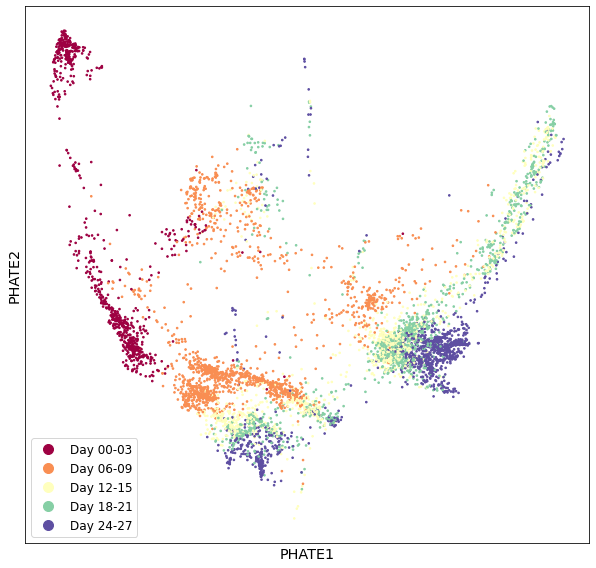

In [13]:
ax = scprep.plot.scatter2d(data_phate, c=data_loom.ca['Sample_nice'], figsize=(12,8), cmap="Spectral",
                           ticks=False, label_prefix="PHATE")
ax.set_aspect('equal')

#### Plotting the fraction of spliced and unspliced reads in each sample

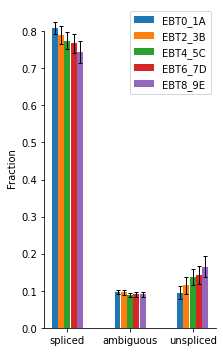

In [14]:
data_loom.plot_fractions()

### Discussion

In pairs, discuss the following questions

1. What do you notice about the number ratio of spliced to unspliced genes?
2. What does this imply about the rate of transcription over time?

## 2. Gene Filtering

Just as we filter and preprocess RNA expression data, we need to do some preprocessing of the `VelocytoLoom` file.

### Score detection levels

Here we do a simple filtering based on the minimum number of cells in which a given gene is detected. We then throw away lowly expressed genes.

In [15]:
# Identify genes with adequate baseline expression
data_loom.score_detection_levels(min_expr_counts=40, min_cells_express=30)

# Keep only genes passing detection threshold
data_loom.filter_genes(by_detection_levels=True)

### Filter highly variable genes

Here, we only keep genes with a high coefficient of variation with respect to mean expression.

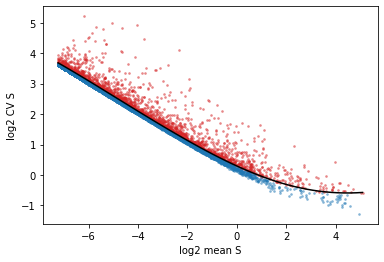

In [16]:
data_loom.score_cv_vs_mean(3000, plot=True, max_expr_avg=35)
data_loom.filter_genes(by_cv_vs_mean=True)

### Filter genes by cluster expression

Here, we keep genes that have adequate spliced and unspliced counts in clusters of the data. The following methods will do the clustering and ensure that we have sufficient spliced and unspliced counts throughout the full dataset.

In [17]:
# Consider number of spliced and unspliced counts globally
data_loom.score_detection_levels(min_expr_counts=0, min_cells_express=0, 
                                 min_expr_counts_U=25, min_cells_express_U=20)

# Consider number of spliced and unspliced counts in clusters
data_loom.score_cluster_expression(min_avg_U=0.01, min_avg_S=0.08)
data_loom.filter_genes(by_detection_levels=True, by_cluster_expression=True)

### Normalize the spliced and unspliced counts by library size 

In [18]:
# Normalize Spliced and Unspliced gene expression matrices by library size.
data_loom._normalize_S(relative_size=data_loom.initial_cell_size,
                       target_size=np.mean(data_loom.initial_cell_size))
data_loom._normalize_U(relative_size=data_loom.initial_Ucell_size,
                       target_size=np.mean(data_loom.initial_Ucell_size))

### Pick a number of principal components to use for kNN smoothing

Text(0, 0.5, 'Explained Variance')

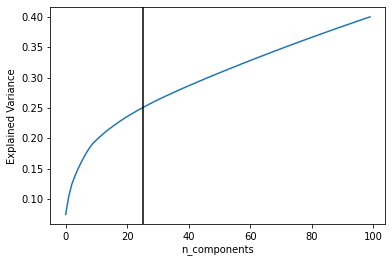

In [19]:
# Pick a number of PCA components
data_loom.perform_PCA()
plt.plot(np.cumsum(data_loom.pca.explained_variance_ratio_)[:100])
#n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.002))[0][0]
n_comps = 25
plt.axvline(n_comps, c="k")
plt.xlabel('n_components')
plt.ylabel('Explained Variance')

### Gene smoothing

Because not all genes are detected in all cells, the ratio of spliced to unspliced is noisy (just like gene expression, but worse), we want to use local neighborhoods in the data to perform imputation and denoising. This is similar to the MAGIC algorithm discussed earlier, but it doesn't use diffusion. In the MAGIC paper, it was shown that MAGIC performs better than kNN for gene denoising, but this isn't our implementation, so we're not going to worry too much about that.

In [20]:
# Denoise the data using kNN

# Change k here to change how much denoising is performed
k = 5
data_loom.knn_imputation(n_pca_dims=n_comps, k=k, 
                         # velocyto uses an algorithm called BalancedKNN
                         # for smoothing. These parameters are go directly
                         # to BalancedKNN
                         balanced=True, b_sight=k*8, b_maxl=k*4, 
                         n_jobs=-1)

### Estimate the rate of transcription

Here, we're going to estimate the rate of transcription for each gene. This involves estimating the steady-state expression for each gene and calculating the rate of transcription as a ratio of the spliced and unspliced molecules in each cell.

In [21]:
# Fit gamma (stable state unspliced to spliced ratio) 
# and calculate gene shift at all cells

# Learn steady-state U/S ratio
data_loom.fit_gammas(limit_gamma=False, fit_offset=False)

# Estimate rate of transcription 
data_loom.predict_U()

# Calculate individual cell "next state"
data_loom.calculate_velocity()
data_loom.calculate_shift(assumption="constant_velocity")
data_loom.extrapolate_cell_at_t(delta_t=1.)

## Gene Scatterplots

Now that we have estimated the rate of transcription and splicing for each cell, we can inspect how well these curves match the data we're observing. Remember that one assumption of RNA-velocity is that the rate of splicing is constant across all cells in a dataset.

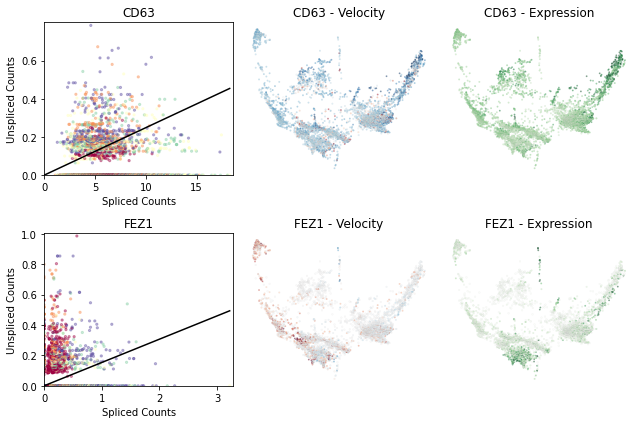

In [22]:
# Plot for a few genes the spliced and unspliced counts, as well as
# The calculated gene velocity, and expression at each cell.

fig, axes = plt.subplots(2, 3, figsize=(9,6))
for gene, axis_row in zip(['CD63', 'FEZ1'], axes):
#for i, gn in enumerate(["FOXD3", 'GATA6']):
    ax_left, ax_middle, ax_right = axis_row
    if not np.any(data_loom.ra["Gene"] == gene):
        # this gene doesn't exist!
        continue
    else:
        gene_idx = np.argwhere(data_loom.ra["Gene"] == gene)[0,0]
    plt.sca(ax_left)
    velocyto.scatter_viz(data_loom.Sx_sz[gene_idx,:], data_loom.Ux_sz[gene_idx,:], s=5,
                         c=data_loom.colorandum, alpha=0.4, rasterized=True)
    ax_left.set_title(gene)
    xnew = np.linspace(0, data_loom.Sx[gene_idx,:].max())
    ax_left.plot(xnew, data_loom.gammas[gene_idx] * xnew + data_loom.q[gene_idx], c="k")
    plt.ylim(0, np.max(data_loom.Ux_sz[gene_idx,:])*1.02)
    plt.xlim(0, np.max(data_loom.Sx_sz[gene_idx,:])*1.02)
    plt.xlabel('Spliced Counts')
    plt.ylabel('Unspliced Counts')
    data_loom.plot_velocity_as_color(gene_name=gene, gs=ax_middle, s=3, rasterized=True)
    plt.title('{} - Velocity'.format(gene))
    data_loom.plot_expression_as_color(gene_name=gene, gs=ax_right, s=3, rasterized=True)
    plt.title('{} - Expression'.format(gene))

plt.tight_layout()

### Discussion
For these questions, it might be helpful to consults figures from the RNA Velocity paper: https://www.ncbi.nlm.nih.gov/pubmed/30089906
1. What do these plots mean given the way RNA velocity is calcualted?
2. How do these plots compare to the figures from [the RNA velocity paper](https://www.nature.com/articles/s41586-018-0414-6)? Compare to Fig. 3b.

## 3. Estimate transition probabilities

Here we take the set of all predicted "next states" for each cell and estimate a future cell profile. Because each gene estimate is noisy, we take averages of neighbors.

This is the most computationally intensive step of RNA-velocity analysis, so it may take 1-3 minutes to finish.

Also, heads up, you may see several red warnings come up. You can ignore these. They are due to the velocyto implementation and not anything we've done here.

In [23]:
# Estimate the transition direction of each cell in gene space
# This is the most compuationally intensive step.
data_loom.estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt", psc=1,
                                   n_neighbors=2000, knn_random=True, sampled_fraction=0.5,
                                   calculate_randomized=True, n_jobs=-1)

/usr/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


#### Calculate the next cell profile in the embedding space

Once we know the expected gene expression profile of each cell, we need to calculate where that cell would appear in the PHATE space to create the velocity plots.

In [24]:
# Calculate from the gene velocity vectors in the embedding space
data_loom.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)

# Calculate a 50x50 grid of velocities over the embedding space
data_loom.calculate_grid_arrows(smooth=0.5, steps=(50, 50), n_neighbors=100)

### Plotting Velocity Vectors

These are the fancy plots highlighted in the RNA velocity paper. Each cell gets an arrow pointing to it's future cell state. You can see the flow of cell states throughout development!

(-116.35976609808827,
 119.75876346713203,
 -94.9370100358334,
 129.62969956975672)

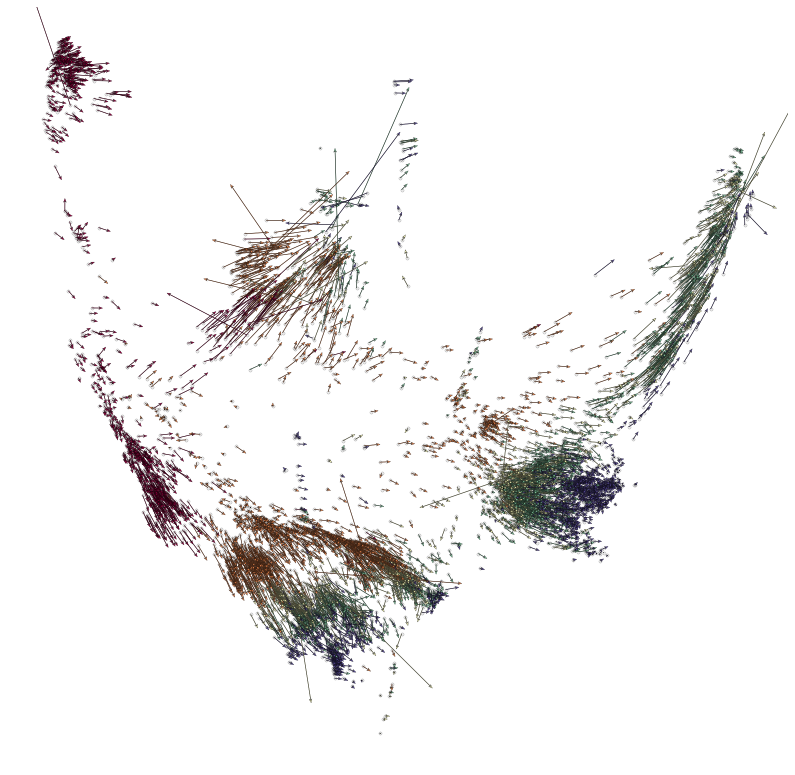

In [25]:
# Plot per cell velocity directions
plt.figure(None,(14,14))
quiver_scale = 10
q_scale=1
ix_choice = np.random.choice(data_loom.embedding.shape[0],
                             size=int(data_loom.embedding.shape[0]/1.), replace=False)

# Plotting each cell using the pyplot scatter function 
plt.scatter(data_loom.embedding[ix_choice, 0], data_loom.embedding[ix_choice, 1],
            c="0.8", alpha=0.4, s=10, edgecolor=(0,0,0,1), lw=0.3, rasterized=True)

# Plotting the arrows 
quiver_kwargs = dict(headaxislength=7, headlength=11, headwidth=8,
                     linewidths=0.25, width=0.00045, edgecolors="k",
                     color=data_loom.colorandum[ix_choice], alpha=1)
plt.quiver(data_loom.embedding[ix_choice, 0], data_loom.embedding[ix_choice, 1], 
           q_scale*data_loom.delta_embedding[ix_choice, 0],
           q_scale*data_loom.delta_embedding[ix_choice, 1],
           scale=quiver_scale, **quiver_kwargs)

plt.axis("off")

### Plot arrows on a grid

Here we're plotting the average arrow for each section of the grid. This is a much "prettier" plot.

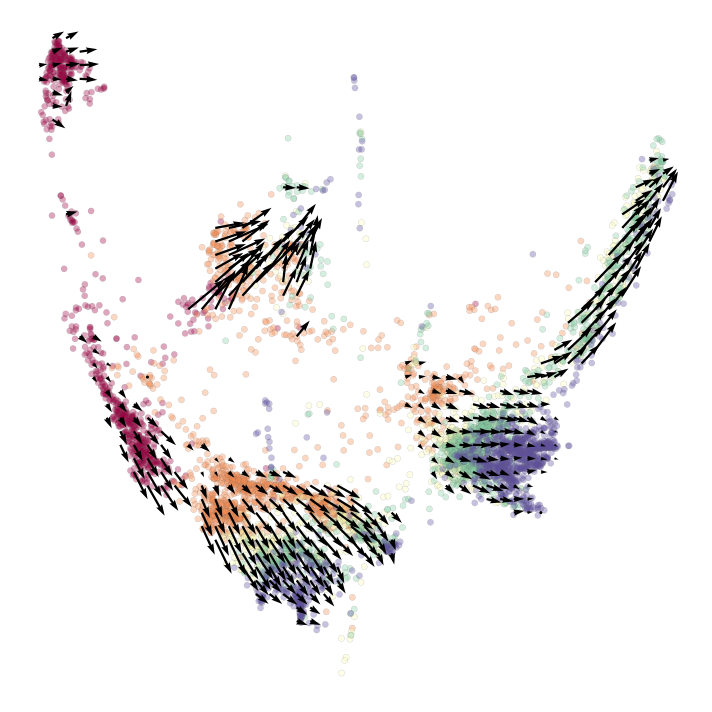

In [26]:
# Plot velocity on grid points smoothing cell velocities.
plt.figure(1,(10,10))

# Plot the arrows
data_loom.plot_grid_arrows(quiver_scale=0.5,
                           scatter_kwargs_dict={"alpha":0.35, "lw":0.35, 
                           "edgecolor":"0.4", "s":38, "rasterized":True},
                           plot_random=False)

plt.tight_layout()

### Discussion

1. Looking at this data, how many end points do you think exist in the EB dataset?

## 4. Identify genes with largest changing velocity

In [27]:
data = pd.DataFrame(data_loom.U + data_loom.S, index=data_loom.ra['Gene'], columns=data_loom.ca['CellID']).T

In [28]:
data = scprep.normalize.library_size_normalize(data)
data = scprep.transform.sqrt(data)

### Cluster the data

Here we're using PHATE to define clusters in a method similar to spectral clustering. You will have to set `n_clusters`. Consult the PHATE plot and determine how many clusters you need so that each "end point" is in a separate cluster.

Note: since clustering is highly influenced by the random initialization, we are setting the seed here to ensure reproducible results.

In [ ]:
phate_op = phate.PHATE(verbose=False, random_state=42).fit(data)

In [42]:
# =======
# Pick a number of clusters
n_clusters = 16
clusters = phate.cluster.kmeans(phate_op, n_clusters=n_clusters, random_state=42)
clusters = scprep.utils.sort_clusters_by_values(clusters, data_phate[0])
# =======

#### Plotting clusters

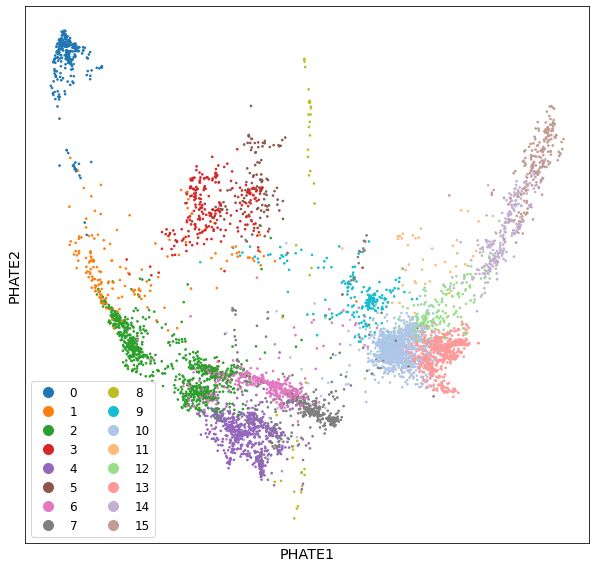

In [43]:
# Plot clusters
ax = scprep.plot.scatter2d(data_phate, c=clusters, figsize=(12,8),
                           ticks=False, label_prefix="PHATE")
ax.set_aspect('equal')

#### Plotting velocity on clusters

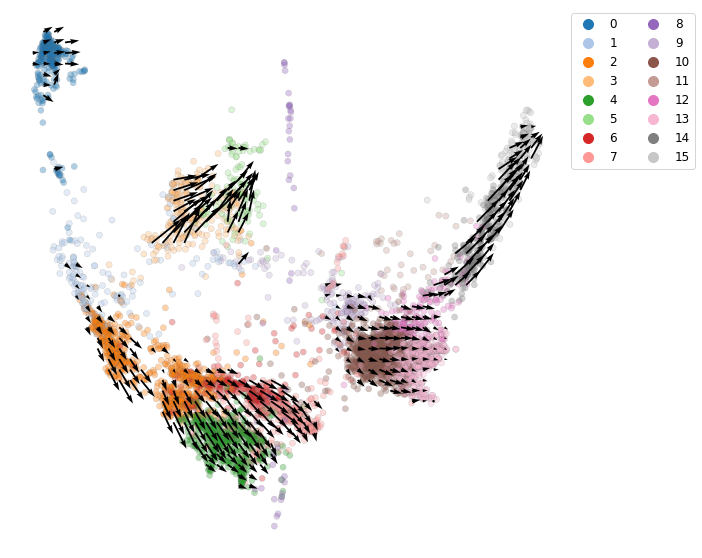

In [44]:
# Plot velocity on grid points smoothing cell velocities.
fig, ax = plt.subplots(figsize=(10,10))

cm = plt.cm.tab20(np.linspace(0, 1, 20))
cmap = {cl:cm[cl] for cl in np.unique(clusters)}
data_loom.colorandum = np.array([cm[cl] for cl in clusters])

# Plot the arrows
data_loom.plot_grid_arrows(
    quiver_scale=0.5,
    scatter_kwargs_dict={"alpha":0.35, "lw":0.35, 
    "edgecolor":"0.4", "s":38, "rasterized":True},
    plot_random=False)

scprep.plot.tools.generate_legend(cmap, ax, bbox_to_anchor=(1,1))

### Running slingshot informed by RNA velocity

Go back and compare these plots to the Slingshot results from the "02_Embryoid_body_trajectory_inference" notebook. Do you think there might be other endpoints in this data?

#### Run slingshot

Looking at the above plots, what do you think the correct `end_cluster` should be for Slingshot? How many do you think there are? Pass the cluster labels as a list to slingshot, e.g. `end_cluster=[0,1,2,3]`

To confirm the results look good, consult the plot of the principal curves and average pseudotime per cell.

In [46]:
import tasklogger
with tasklogger.log_task("Slingshot"):
    # =========
    # Set the end points for Slingshot
    results = scprep.run.Slingshot(data_phate, clusters, start_cluster=[0], end_cluster=[4, 5, 7, 8, 13, 15])
    # =========

Calculating Slingshot...


Calculated Slingshot in 136.19 seconds.


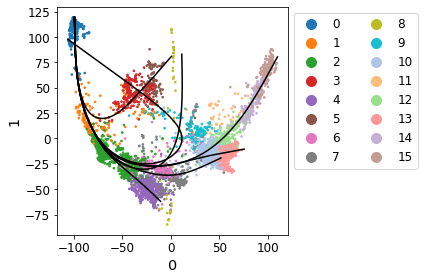

In [47]:
ax = scprep.plot.scatter2d(data_phate, c=clusters, legend_anchor=(1,1))
for curve in results['curves']:
    ax.plot(curve[:,0], curve[:,1], c='k')

### Calculate the average slingshot pseudotime per cell

In [48]:
# To calculate the average slingshot pseudotime, we can use np.nanmean
avg_slingshot_pseudotime = np.nanmean(results['pseudotime'], axis=1)

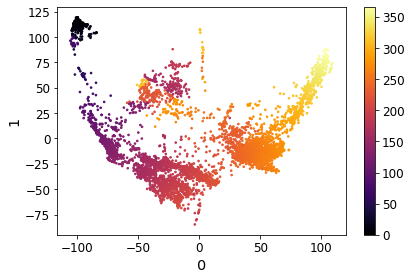

In [49]:
ax = scprep.plot.scatter2d(data_phate, c=avg_slingshot_pseudotime)

### Discussion

1. With your groups, find a number of clusters and set of endpoints that give you results that match the PHATE plot and the RNA velocity results.

### Calculate average velocity per cluster

Here we calculate the velocity for each gene in each cell, then use `pd.DataFrame.groupby()` to calculate the average velocity in each cluster.

Each row of the resulting dataset corresponds to a cluster and each column is a gene.

In [50]:
velocity = pd.DataFrame(data_loom.velocity, index=data_loom.ra['Gene'], columns=data_loom.ca['CellID']).T

mean_velocity_per_cluster = velocity.groupby(clusters).mean()
mean_velocity_per_cluster

,MRPL20,ACOT7,RERE,ENO1,CTNNBIP1,SRM,RCC2,LUZP1,HNRNPR,SRSF10,...,KIF4A,PGK1,DIAPH2,RPL36A,BEX3,PRPS1,PLS3,STK26,DKC1,EIF1AY
0,-0.135510,-0.037875,0.301562,-0.057522,-0.006766,-0.047573,-0.047704,-0.026392,-0.033300,-0.241481,...,0.007584,-0.043234,0.061634,-0.109823,-0.226887,-0.027696,-0.032650,-0.021621,-0.063618,-0.072672
1,-0.128749,-0.027890,0.246291,-0.090231,-0.046435,-0.033881,0.004288,-0.026015,-0.044426,-0.064626,...,0.008609,-0.028065,0.056878,-0.110745,-0.237028,-0.033845,0.024449,-0.019959,-0.059855,-0.094504
2,-0.076772,-0.024147,0.306372,-0.103584,-0.060303,-0.025503,0.004892,-0.029242,-0.040282,-0.101533,...,0.013959,-0.027708,0.060243,-0.114498,-0.133723,-0.031899,-0.007478,-0.016523,-0.060750,-0.049488
3,-0.077195,-0.016627,0.388153,-0.069420,-0.047501,-0.010714,-0.032282,-0.034218,-0.010524,0.059146,...,-0.001531,-0.030646,0.115667,-0.096761,-0.169334,-0.018291,-0.021050,-0.015822,-0.034992,-0.063926
4,-0.048135,-0.033086,0.296230,-0.122439,-0.019098,-0.023196,-0.006329,0.002878,-0.005307,0.384230,...,0.011391,-0.039348,0.046394,-0.064828,-0.107513,-0.028466,0.025233,0.005647,-0.041915,-0.006687
5,-0.037564,-0.012100,0.404016,-0.067504,-0.023658,-0.023040,0.012777,0.002194,-0.017355,0.085708,...,-0.000837,-0.022476,0.029362,-0.067993,-0.129529,0.009764,-0.000279,0.030394,-0.019108,0.004695
6,-0.068231,-0.020540,0.298978,-0.078515,-0.038492,-0.027800,-0.012675,-0.024142,-0.007827,0.354649,...,0.014709,-0.040128,0.048991,-0.112205,-0.133134,-0.011561,-0.000603,-0.001386,-0.077155,-0.025563
7,-0.031081,-0.014088,0.265690,-0.087659,-0.020585,-0.034933,-0.025565,0.014661,0.004100,0.440339,...,0.012215,-0.028004,0.067324,-0.089140,-0.084351,-0.022913,0.039693,-0.002174,-0.043041,-0.012965
8,-0.033682,0.039069,0.336752,-0.105500,-0.020325,-0.041438,0.025032,-0.001105,-0.022704,0.325931,...,0.000000,-0.006417,0.056316,-0.053900,-0.061578,0.014520,-0.004483,-0.001904,-0.029171,-0.047775
9,-0.065892,-0.011031,0.325447,-0.074795,-0.030699,-0.024628,-0.028133,-0.039899,-0.028044,0.147484,...,0.008161,-0.035473,0.126375,-0.081675,-0.216883,-0.026329,0.010813,-0.012804,-0.064072,-0.076115


#### Print the genes with the highest mean velocity

In [51]:
# choose a cluster id
cluster_id = 0
mean_velocity_per_cluster.loc[cluster_id].sort_values(ascending=False).head(20)

RPL26          2.101696
TXNRD1         2.046426
SNRPD3         0.828249
SYT1           0.541593
EPCAM          0.500673
APOO           0.424649
TCF7L2         0.316953
MRPL13         0.316553
AC104041.1     0.305640
RERE           0.301562
JAKMIP2-AS1    0.285737
H2AFJ          0.279028
TPM1           0.239807
LRBA           0.233146
TIMP3          0.222895
WWOX           0.222030
ROR1           0.220698
GABRB3         0.209301
EHBP1          0.201364
MRPS7          0.199408
Name: 0, dtype: float64

#### Plotting expression ordered by pseudotime

<AxesSubplot:xlabel='Pseudotime', ylabel='SYT1'>

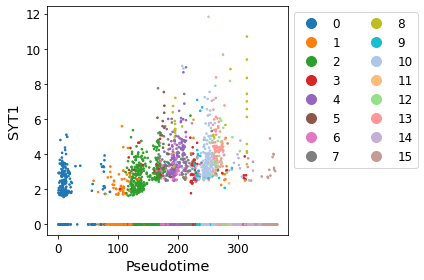

In [52]:
scprep.plot.scatter(avg_slingshot_pseudotime, data['SYT1'], 
                    c=clusters, xlabel='Pseudotime', legend_anchor=(1,1))

#### Run MAGIC

Because the expression data is so noisy, it's hard to see much here with just a single gene. Let's clean it up with MAGIC and see if we can see any clear trends.

In [53]:
import magic

In [54]:
np.random.seed(42)
data_magic = magic.MAGIC(t=4).fit_transform(data)

Calculating MAGIC...
  Running MAGIC on 5999 cells and 1270 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.14 seconds.
    Calculating KNN search...
    Calculated KNN search in 6.12 seconds.
    Calculating affinities...
    Calculated affinities in 4.04 seconds.
  Calculated graph and diffusion operator in 11.39 seconds.
  Calculating imputation...


/home/scottgigante/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))


  Calculated imputation in 0.76 seconds.
Calculated MAGIC in 12.37 seconds.


/home/scottgigante/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


<AxesSubplot:xlabel='Pseudotime', ylabel='SYT1'>

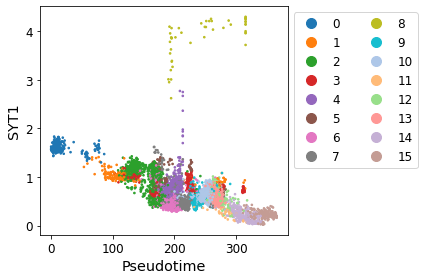

In [55]:
scprep.plot.scatter(avg_slingshot_pseudotime, data_magic['SYT1'], 
                    c=clusters, xlabel='Pseudotime', legend_anchor=(1,1))

### Discussion

1. Pick a cluster that looks like it has high RNA velocity in the above plots (each member of your group should pick a different cluster)
2. Get the top 20 genes with the high average velocity in that cluster
3. Plot the expression of some of those genes against pseudotime
4. Does pseudotime ordering match the RNA velocity prediction for your cluster?
5. Identify one gene for which pseudotime and RNA velocity agree and one for which they do not

As a group, compare your results.